# Plant Pathology 2021

https://www.kaggle.com/competitions/plant-pathology-2021-fgvc8

## Setup

In [1]:
import os
import glob
from pathlib import Path
import random
import gc
from PIL import Image
from typing import Tuple, Dict, List

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader

import torchinfo

In [2]:
IS_KAGGLE = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

COMP_NAME = 'plant-pathology-2021-fgvc8'
if COMP_NAME is None:
    raise NameError('COMP_NAME has not been initialized')

DATA_PATH = Path('../input/' + COMP_NAME) if IS_KAGGLE else Path('./data')

RANDOM_SEED = 42
BATCH_SIZE = 64
IMG_SIZE = 256

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
print('kaggle:', 'Y' if IS_KAGGLE else 'N')
print('torch version:', torch.__version__)
print('device:', DEVICE)
print(torch.cuda.device_count(), 'GPU(s) available')

kaggle: N
torch version: 2.0.1
device: cuda
2 GPU(s) available


In [4]:
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Load Data

In [5]:
path = Path('./data')
if not DATA_PATH.exists():
    import zipfile, kaggle
    kaggle.api.competition_download_cli(COMP_NAME)
    zipfile.ZipFile(f'{COMP_NAME}.zip').extractall(DATA_PATH)

In [6]:
all_data = pd.read_csv(DATA_PATH / 'train.csv')
all_data['labels'] = all_data['labels'].apply(lambda x: x.split(' '))

print('train:', all_data.shape)

train: (18632, 2)


In [7]:
all_data.head(5)

,image,labels
0,800113bb65efe69e.jpg,[healthy]
1,8002cb321f8bfcdf.jpg,"[scab, frog_eye_leaf_spot, complex]"
2,80070f7fb5e2ccaa.jpg,[scab]
3,80077517781fb94f.jpg,[scab]
4,800cbf0ff87721f8.jpg,[complex]


## Data Exploration

In [8]:
all_data['labels'].value_counts()

labels
[scab]                                 4826
[healthy]                              4624
[frog_eye_leaf_spot]                   3181
[rust]                                 1860
[complex]                              1602
[powdery_mildew]                       1184
[scab, frog_eye_leaf_spot]              686
[scab, frog_eye_leaf_spot, complex]     200
[frog_eye_leaf_spot, complex]           165
[rust, frog_eye_leaf_spot]              120
[rust, complex]                          97
[powdery_mildew, complex]                87
Name: count, dtype: int64

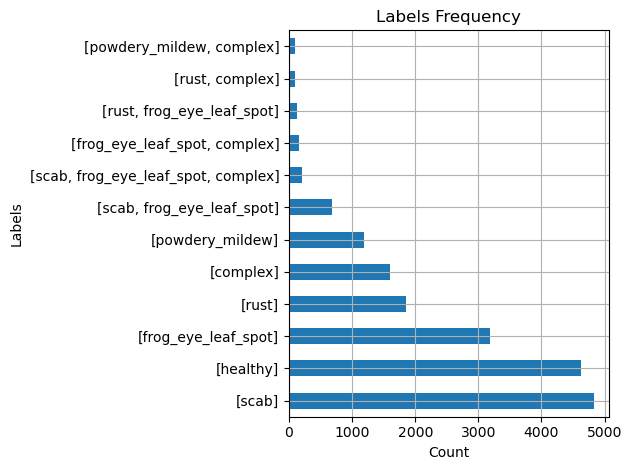

In [9]:
all_data['labels'].value_counts().plot(kind='barh')
plt.title('Labels Frequency')
plt.xlabel('Count')
plt.ylabel('Labels')
plt.grid(True)
plt.tight_layout()

plt.show()

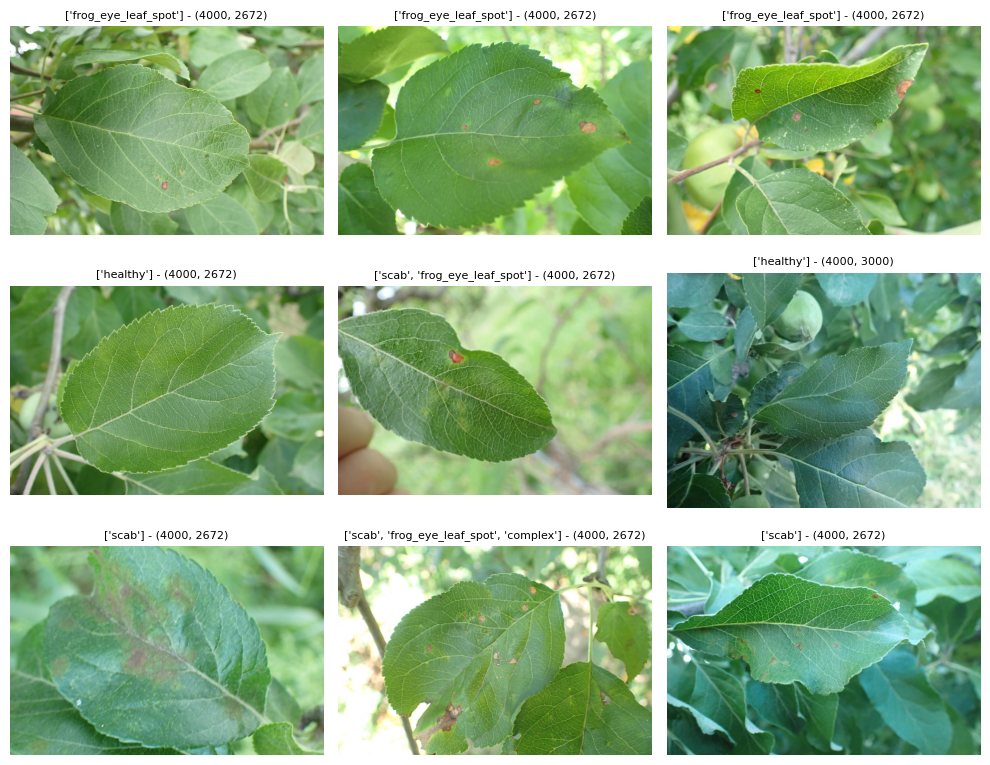

In [10]:
fig = plt.figure(figsize=(10,8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = random.randint(0, len(all_data)-1)
    img = Image.open(DATA_PATH / 'train_images' / (all_data['image'][sample_idx]))

    ax = fig.add_subplot(rows, cols, i)
    ax.imshow(img)
    plt.title(f"{all_data['labels'][sample_idx]} - {img.size}", fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [11]:
m = MultiLabelBinarizer()
encoded_labels = pd.DataFrame(m.fit_transform(all_data['labels']), columns=m.classes_, index=all_data.index)
print(encoded_labels.head(5))

   complex  frog_eye_leaf_spot  healthy  powdery_mildew  rust  scab
0        0                   0        1               0     0     0
1        1                   1        0               0     0     1
2        0                   0        0               0     0     1
3        0                   0        0               0     0     1
4        1                   0        0               0     0     0


In [12]:
classes = list(encoded_labels.columns)
print(classes)

['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']


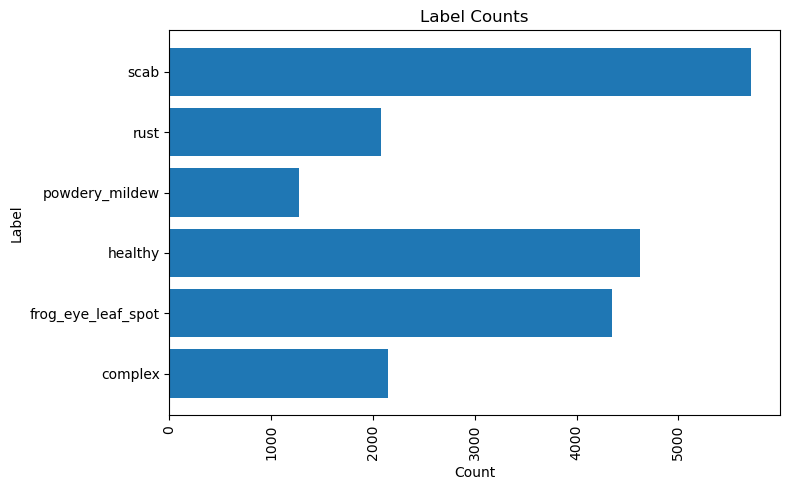

In [13]:
plt.figure(figsize=(8, 5))
plt.barh(encoded_labels.columns, encoded_labels.sum().values)
plt.xlabel('Count')
plt.ylabel('Label')
plt.title('Label Counts')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

## Prepare Training/Validation Data

In [14]:
class PlantDataset(Dataset):

    def __init__(self, df: pd.DataFrame, transform: v2.Transform = None) -> None:
        super().__init__()
        self.images = df['image'].values
        self.labels = df['labels'].values
        self.transform = transform
        self.encoded_labels = torch.from_numpy(MultiLabelBinarizer().fit_transform(df['labels']))

    def load_image(self, index: int) -> Image.Image:
        img_path = DATA_PATH / 'train_images' / self.images[index]
        return Image.open(img_path).convert('RGB')

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        X = self.load_image(index)
        y = self.encoded_labels[index]

        if self.transform:
            X = self.transform(X)
        return (X, y)


In [15]:
transform_mean = (0.485, 0.456, 0.406)
transform_std = (0.229, 0.224, 0.225)

transform = v2.Compose([
    v2.Resize(IMG_SIZE),
    v2.RandomCrop(IMG_SIZE),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.RandomRotation(2),
    # v2.ColorJitter(brightness=(0.75, 0.9), contrast=(0.75, 0.9), saturation=(1.5,2.0)),
    v2.ColorJitter(saturation=(1.0,1.5), contrast=(0.6, 0.8), brightness=(0.85, 0.95)),
    v2.ToTensor(),
    v2.Normalize(mean=transform_mean, std=transform_std),
])

all_ds = PlantDataset(all_data, transform)

print(len(all_ds), 'samples')

18632 samples


In [16]:
total_samples = len(all_ds)
train_size = int(total_samples * 0.8)
valid_size = total_samples - train_size

train_ds, valid_ds = torch.utils.data.random_split(all_ds, [train_size, valid_size])

print('train:', len(train_ds), 'samples')
print('valid:', len(valid_ds), 'samples')

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

train: 14905 samples
valid: 3727 samples


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


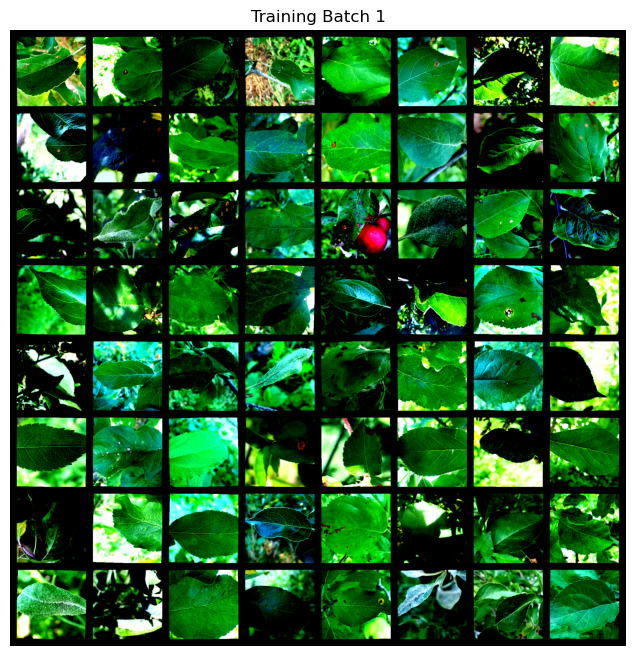

In [17]:
grid_iter = iter(train_loader)
grid_X, grid_y = next(grid_iter)
grid = torchvision.utils.make_grid(grid_X, nrow=8, padding=25)

plt.figure(figsize=(10, 8))
plt.imshow(grid.permute(1, 2, 0)) # (3, IMG_SIZE, IMG_SIZE) -> (IMG_SIZE, IMG_SIZE, 3)
plt.title("Training Batch 1")
plt.axis('off')

plt.show()

## Build/Train Model

Windows + Jupyter seems to have problems with running dataloaders with `num_workers` > 0 ...

So, had to train model outside of jupyter using `./plant-pathology.py`.
The trained model gets saved to `plant-pathology.pth`

In [18]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Sequential(
    nn.Linear(in_features=model.fc.in_features, out_features=len(classes)),
    nn.Sigmoid(),
)

model.load_state_dict(torch.load('./plant-pathology.pth'))
model = model.to(DEVICE)

## Submission

In [29]:
class TestDataset(Dataset):
    def __init__(self, test_path: Path, transform: v2.Transform = None):
        self.test_path = test_path
        self.transform = transform

    def __len__(self) -> int:
        return len(glob.glob(f'{self.test_path}/*.jpg'))

    def __getitem__(self, idx: int) -> Image:
        img_path = os.path.join(self.test_path, os.listdir(self.test_path)[idx])
        img = Image.open(img_path)
        
        if self.transform:
            img = self.transform(img)
        return img


In [30]:
test_path = DATA_PATH/'test_images'

test_transform = v2.Compose([
    v2.Resize((IMG_SIZE, IMG_SIZE)),
    v2.ToTensor(),
    v2.Normalize(transform_mean, transform_std),
])

test_ds = TestDataset(test_path, transform=test_transform)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

print('Test:', len(test_ds), 'samples')

Test: 3 samples


In [31]:
labels = []
threshold = 0.5

model.eval()

with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)

        preds = (outputs > threshold).int().cpu().numpy().tolist()
        for i, pred in enumerate(preds):
            l = [classes[j] for j,x in enumerate(pred) if x == 1]
            if len(l) == 0:
                l = ['healthy'] # fall back to healthy
            labels.append(' '.join(l))

print(labels)

submission = pd.DataFrame({'image': os.listdir(test_path), 'labels': labels})
submission.to_csv('submission.csv', index=False)

['healthy', 'frog_eye_leaf_spot', 'frog_eye_leaf_spot']
